# Structured Names
This notebook describes how to use structured names to check SBML models for moiety balance.

In [1]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

In [2]:
from SBMLLint.common.simple_sbml import modelIterator

In [3]:
iterator = modelIterator(initial=19, final=25)
for item in iterator:
    print(item.filename)

BIOMD0000000241_url.xml
BIOMD0000000350_url.xml
MODEL0847712949_url.xml
BIOMD0000000346_url.xml
BIOMD0000000256_url.xml
BIOMD0000000402_url.xml


In [4]:
import init
from SBMLLint.tools import sbmllint

# The first step in glycolysis, expressed
# in the Antimony language.
model = """
Glu + A__P_3 -> Glu_P + A_P_P; 1
Glu = 0
A_P_P_P = 0
Glu_P = 0
A_P_P = 0
"""
_ = sbmllint.lint(model)


0 of 1 reactions have imbalances.



In [5]:
# The first step in glycolysis, with an error (wrongly goes to A instead of A_P_P)
model = """
Glu + A_P_P_P -> Glu_P + A_P; 1
"""
_ = sbmllint.lint(model)


1 of 1 reactions have imbalances.

***_J0: Glu + A_P_P_P -> Glu_P + A_P
Excess moieties in reactants
  P: 1.00




## Sturctured Names in BioModels

In [11]:
path = os.path.join(cn.ANALYSIS_STRUCTURED_NAMES_DIR, "analyze_structured_names.csv")
df = pd.read_csv(path)
df.head()

,filename,is_structured,num_boundary_reactions,total_reactions,num_imbalanced_reactions,num_balanced_reactions,frac_balanced_reactions,frac_Boundary_reactions
0,BIOMD0000000100_url.xml,False,5,10,10,0,0.0,0.500000
1,BIOMD0000000325_url.xml,False,7,10,10,0,0.0,0.700000
2,BIOMD0000000482_url.xml,False,4,29,29,0,0.0,0.137931
3,BIOMD0000000462_url.xml,False,0,8,8,0,0.0,0.000000
4,BIOMD0000000352_url.xml,False,8,12,12,0,0.0,0.666667


In [13]:
len(df)

23

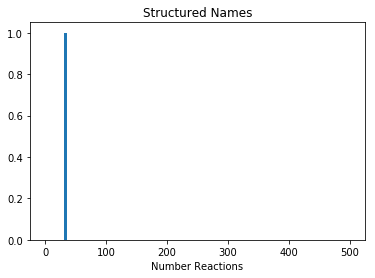

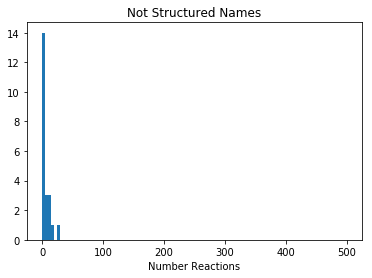

In [10]:
def plotIsStructured(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.hist(df1[cn.TOTAL_REACTIONS], bins=100, range=(0, 500))
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.show()
plotIsStructured(True)
plotIsStructured(False)

In [ ]:
def plotFrcBoundary(val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.scatter(df1[cn.TOTAL_REACTIONS], df1[cn.FRAC_BOUNDARY_REACTIONS])
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.ylabel("Fraction Boundary")
    plt.show()
plotFrcBoundary(True)
plotFrcBoundary(False)

In [ ]:
def plotFrcBalanced():
    df1 = df[df[cn.IS_STRUCTURED]]
    xv = (1.0*df1[cn.TOTAL_REACTIONS] - df1[cn.NUM_BOUNDARY_REACTIONS]) / df1[cn.NUM_REACTIONS]
    plt.scatter(xv, df1[cn.FRAC_BALANCED_REACTIONS])
    title = "Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Non-Boundary Reactions")
    plt.ylabel("Fraction Balanced")
    plt.xlim([0, 1.1])
    plt.show()
plotFrcBalanced()

**To Do**
1. Identify the missing files. Likely a problem with the iterator?